In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import seaborn as sns
import cmocean
import datetime
import os
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix

In [3]:
# import own modules
import function_file as fp
from function_file import *
#fp.numeric_cols
#fp.pop_parameters
#fp.pop_parameters_dict
#fp.plot_hist_mult
#fp.plot_box_mult

In [4]:
# Retrieve path and load the data
path = os.getcwd()
dr = pd.read_csv(path+"/train.csv")
dt = pd.read_csv(path+"/test.csv")

# Number of rows and columns
print('dr train', dr.shape)
print('df test', dt.shape)

dr.head(3)

dr train (6895, 70)
df test (767, 69)


,id,short_name,overall,potential,value_eur,wage_eur,birthday_date,height_cm,weight_kg,club_name,...,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,position
0,216302,E. García,71,71,1400000.0,10000,1989-12-28,176,73,Club Atlético de San Luis,...,65,66,65,14,11,12,12,12,NaN,LB
1,237867,D. Cancola,65,71,1000000.0,2000,1996-10-23,183,73,Ross County FC,...,65,61,58,10,13,7,6,11,NaN,LDM
2,253472,E. Kahl,65,77,1600000.0,2000,2001-09-27,178,69,Aarhus GF,...,60,58,59,10,10,8,10,11,NaN,LWB


#### player identification and overall qualification variables  
- id: Unique identifier for each player.
- short_name: Short name or nickname of the player. [X]
- birthday_date: Player's date of birth. [X]
- height_cm: Player's height in centimeters. [D]
- weight_kg: Player's weight in kilograms. [D]

- overall: Player's overall rating, representing their overall skill level [D]
- potential: Player's potential rating, indicating their potential skill growth. [D]
- international_reputation: Player's international reputation level. [D]
- club_name: Name of the player's club.[X]
- league_name: Name of the league the club belongs to.[D]
- league_level [D]
- club_jersey_number [D]
- club_loaned_from [X]
- club_joined [X]
- club_contract_valid_until [X]
- nationality_name [D]
- nation_jersey_number [X]

- work_rate [D]
- body_type [D]
- real_face [X]
- player_tags [X]
- player_traits [D]
  
#### player financial metrics  
- value_eur: Player's market value in euros.
- wage_eur: Player's weekly wage in euros.
- release_clause_eur

  
#### player position related metrics  
- position: Player's preferred playing position.[TARGET VARIABLE]
- preferred_foot: Player's preferred kicking foot (left or right).
- weak_foot: Player's weak foot rating, indicating their weaker kicking foot's ability.

#### Skills
- skill_dribbling
- skill_curve
- skill_fk_accuracy
- skill_long_passing
- skill_ball_control
- skill_moves: Player's skill moves rating, representing their dribbling and ball control skills.

#### high level attributes  
- pace 
- shooting 
- passing 
- dribbling 
- defending 
- physic: Attributes representing different aspects of a player's playing style and skills.

#### mentality attributes  
- mentality_aggression
- mentality_vision
- mentality_composure: Attributes representing mental aspects of a player's game.
- mentality_interceptions
- mentality_positioning
- mentality_penalties
   
#### attacking attributes  
- attacking_crossing
- attacking_finishing 
- attacking_heading_accuracy: Attributes related to attacking and finishing skills.'attacking_crossing', 
- attacking_heading_accuracy
- attacking_short_passing
- attacking_volleys

#### movement attributes 
- movement_acceleration
- movement_sprint_speed
- movement_agility: Attributes related to a player's speed and agility.
- movement_reactions
- movement_balance

#### strength attributes 
- power_shot_power
- power_jumping
- power_stamina: Attributes representing a player's physical power and endurance.
- power_strength
- power_long_shots

#### defending attributes
- defending_marking_awareness
- defending_standing_tackle
- defending_sliding_tackle: Attributes representing a player's defensive skills.


#### Goalkeeper attributes  

- goalkeeping_diving
- goalkeeping_handling
- goalkeeping_positioning: Goalkeeping attributes related to diving, handling, and positioning.
- goalkeeping_reflexes
- goalkeeping_speed: Attributes representing a goalkeeper's reflexes and speed.
- goalkeeping_kicking

## Merge Train and Test dataset

Create function for merging train and test datasets

In [5]:
# Create column to differentiate train from test
dr['is_test'] = 0
dt['is_test'] = 1

In [6]:
# union both datasets
df = pd.concat([dr, dt])

In [7]:
# Unit test
dr.shape[0] + dt.shape[0] == df.shape[0]

True

In [8]:
# Unit test
df['is_test'].value_counts()

0    6895
1     767
Name: is_test, dtype: int64

# Checking for missing values

Create function for showing missing values and doing inputations

In [9]:
def missing_value(dataset):
    mis = dataset.isna().mean()
    return mis[mis > 0].sort_values(ascending = False)

In [10]:
missing_value(df)

club_loaned_from        0.948316
nation_jersey_number    0.939441
goalkeeping_speed       0.908510
player_tags             0.888280
player_traits           0.375098
position                0.100104
pace                    0.091490
shooting                0.091490
passing                 0.091490
dribbling               0.091490
defending               0.091490
physic                  0.091490
release_clause_eur      0.052336
club_joined             0.051684
value_eur               0.000653
dtype: float64

Can be dropped:
- club_loaned_from
- nation_jersey_number
- player_tags

Needs transformation: 
- goalkeeping_speed
- player_traits

#### Drop club_loaned_from, nation_jersey_number and player_tags


In [11]:
#Drop columns
columns_k = ['club_loaned_from','nation_jersey_number','player_tags','club_joined']

df.drop(columns=columns_k, inplace=True)

#### Transform GK_speed column to boolean

In [12]:
df[['id','goalkeeping_diving','goalkeeping_handling','goalkeeping_positioning','goalkeeping_reflexes',
   'goalkeeping_speed','goalkeeping_kicking']].isna().mean()

id                         0.00000
goalkeeping_diving         0.00000
goalkeeping_handling       0.00000
goalkeeping_positioning    0.00000
goalkeeping_reflexes       0.00000
goalkeeping_speed          0.90851
goalkeeping_kicking        0.00000
dtype: float64

In [13]:
# Replace NAN for 0 and non nulls for 1
df['is_GK'] = df['goalkeeping_speed'].apply(lambda x: 0 if pd.isnull(x) else 1)

In [14]:
# unit test - check for nulls
df['is_GK'].isna().mean()

0.0

In [15]:
# Unit test - Checking if relation GK_speed to GK position in training is 1=1
res1 = df['is_GK'][df['is_test']==0].sum()
res2 = df['goalkeeping_speed'][df['is_test']==0].notnull().sum()

print(res1,res2)

631 631


In [16]:
# Unit test - check again missing values
df[['id','goalkeeping_diving','goalkeeping_handling','goalkeeping_positioning','goalkeeping_reflexes',
   'goalkeeping_speed','goalkeeping_kicking','is_GK']].isna().mean()

id                         0.00000
goalkeeping_diving         0.00000
goalkeeping_handling       0.00000
goalkeeping_positioning    0.00000
goalkeeping_reflexes       0.00000
goalkeeping_speed          0.90851
goalkeeping_kicking        0.00000
is_GK                      0.00000
dtype: float64

In [17]:
#Drop GK columns
columns_gk = ['goalkeeping_diving','goalkeeping_handling','goalkeeping_positioning','goalkeeping_reflexes',
   'goalkeeping_speed','goalkeeping_kicking']

df.drop(columns=columns_gk, inplace=True)

In [18]:
df.head()

,id,short_name,overall,potential,value_eur,wage_eur,birthday_date,height_cm,weight_kg,club_name,...,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,position,is_test,is_GK
0,216302,E. García,71,71,1400000.0,10000,1989-12-28,176,73,Club Atlético de San Luis,...,53,48,58,66,65,66,65,LB,0,0
1,237867,D. Cancola,65,71,1000000.0,2000,1996-10-23,183,73,Ross County FC,...,48,62,46,59,65,61,58,LDM,0,0
2,253472,E. Kahl,65,77,1600000.0,2000,2001-09-27,178,69,Aarhus GF,...,58,60,31,65,60,58,59,LWB,0,0
3,223994,S. Mugoša,72,72,2300000.0,5000,1992-02-26,188,81,Incheon United FC,...,76,60,75,75,16,22,19,LS,0,0
4,251635,A. Țigănașu,65,65,525000.0,3000,1990-06-12,179,74,FC Botoşani,...,60,52,52,58,64,61,58,LB,0,0


### Transforming Player traits

Leave it for later, once we've analyzed the rest of variables

In [19]:
#Check Unique values for player_tags - Check what are the proportions of player tags per position
df.groupby('player_traits',dropna = False)['id'].count().sort_values(ascending = False)

player_traits
NaN                                                                                                    2874
Speed Dribbler (AI)                                                                                     309
Power Header                                                                                            194
Dives Into Tackles (AI)                                                                                 188
Long Passer (AI)                                                                                        176
                                                                                                       ... 
Leadership, Flair, Team Player                                                                            1
Leadership, Flair, Playmaker (AI)                                                                         1
Leadership, Flair, Outside Foot Shot, Team Player, Chip Shot (AI), Technical Dribbler (AI)                1
Leadership, Fl

In [20]:
# remove AI and strip excess space
df['player_traits'] = df['player_traits'].apply(
    lambda x: x.replace('(AI)', '').strip() if isinstance(x, str) else x
)

In [21]:
#Saving traits to different columns
trait_columns = df['player_traits'].str.split(',', expand=True)

In [22]:
# Concatenate the new columns with the original DataFrame
df = pd.concat([df, trait_columns], axis=1)

In [23]:
#Change name of columns
df.rename(columns={0:'trait_1',1:'trait_2',2:'trait_3',3:'trait_4',4:'trait_5',5:'trait_6',6:'trait_7' }, inplace=True)

In [24]:
df.iloc[:,60:]

,is_test,is_GK,trait_1,trait_2,trait_3,trait_4,trait_5,trait_6,trait_7
0,0,0,Early Crosser,None,None,None,None,None,None
1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,Speed Dribbler,None,None,None,None,None,None
3,0,0,Finesse Shot,None,None,None,None,None,None
4,0,0,Solid Player,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...
762,1,0,Speed Dribbler,None,None,None,None,None,None
763,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
764,1,0,Power Header,None,None,None,None,None,None
765,1,0,Solid Player,Dives Into Tackles,Leadership,Power Header,None,None,None


In [25]:
traits_columns = ['trait_1', 'trait_2', 'trait_3', 'trait_4', 'trait_5', 'trait_6', 'trait_7']
df['num_traits'] = df[traits_columns].notna().sum(axis=1)

In [26]:
#### Calculating number of traits per player
df.iloc[:,60:]

,is_test,is_GK,trait_1,trait_2,trait_3,trait_4,trait_5,trait_6,trait_7,num_traits
0,0,0,Early Crosser,None,None,None,None,None,None,1
1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,0,0,Speed Dribbler,None,None,None,None,None,None,1
3,0,0,Finesse Shot,None,None,None,None,None,None,1
4,0,0,Solid Player,None,None,None,None,None,None,1
...,...,...,...,...,...,...,...,...,...,...
762,1,0,Speed Dribbler,None,None,None,None,None,None,1
763,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
764,1,0,Power Header,None,None,None,None,None,None,1
765,1,0,Solid Player,Dives Into Tackles,Leadership,Power Header,None,None,None,4


In [27]:
# temporarily drop player traits
columnas = ['trait_1','trait_2','trait_3','trait_4','trait_5','trait_6','trait_7','player_traits']
df.drop(columns=columnas, inplace=True)

In [28]:
df.iloc[:,60:]

,is_GK,num_traits
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1
...,...,...
762,0,1
763,0,0
764,0,1
765,0,4


##### We will continue later exploring this columns

## Feature imputations

In [29]:
missing_value(df)

position              0.100104
pace                  0.091490
shooting              0.091490
passing               0.091490
dribbling             0.091490
defending             0.091490
physic                0.091490
release_clause_eur    0.052336
value_eur             0.000653
dtype: float64

In [30]:
imputers = ['overall',
 'potential',
 'value_eur',
 'wage_eur',
 'height_cm',
 'weight_kg',
 'league_level',
 'weak_foot',
 'skill_moves',
 'international_reputation',
 'release_clause_eur',
 'pace',
 'shooting',
 'passing',
 'dribbling',
 'defending',
 'physic',
 'attacking_crossing',
 'attacking_finishing',
 'attacking_heading_accuracy',
 'attacking_short_passing',
 'attacking_volleys',
 'skill_dribbling',
 'skill_curve',
 'skill_fk_accuracy',
 'skill_long_passing',
 'skill_ball_control',
 'movement_acceleration',
 'movement_sprint_speed',
 'movement_agility',
 'movement_reactions',
 'movement_balance',
 'power_shot_power',
 'power_jumping',
 'power_stamina',
 'power_strength',
 'power_long_shots',
 'mentality_aggression',
 'mentality_interceptions',
 'mentality_positioning',
 'mentality_vision',
 'mentality_penalties',
 'mentality_composure',
 'defending_marking_awareness',
 'defending_standing_tackle',
 'defending_sliding_tackle',
 'num_traits']

In [31]:
# We will apply KNN to the rest of features with missing values
# Specify the columns to impute
columns_to_impute = imputers

# Create a KNNImputer object with k=3 
imputer = KNNImputer(n_neighbors=3) 

# Perform KNN imputation only on the specified columns for the training data
df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

## Feature Engineering

### Create function for calculating player's age

In [32]:
# Calculate age of players
df['birthday_date'] = pd.to_datetime(df['birthday_date'], format='%Y-%m-%d', errors='coerce')
df['today'] = pd.to_datetime('2022-11-01',format='%Y-%m-%d', errors='coerce')


df['age'] = ((df['today'] - df['birthday_date'])/np.timedelta64(1, 'Y'))
df['age'] = df['age'].astype(int)

Create function for clustering positions into goalkeeper, defender, midfielder and attacker

In [33]:
df.position.unique()

array(['LB', 'LDM', 'LWB', 'LS', 'RW', 'GK', 'LCM', 'RM', 'RCM', 'LW',
       'LCB', 'RB', 'RCB', 'CDM', 'RDM', 'CAM', 'CB', 'ST', 'RS', 'LM',
       'RWB', 'LF', 'RF', 'CM', nan], dtype=object)

In [34]:
# Creating high level position categories
conditions = [
    df['position'].isin(['GK']),
     df['position'].isin(['LB','LCB','CB','RCB','RB','LWB','LDM','CDM','RDM','RWB']),
     df['position'].isin(['LM','LCM','CM','RCM','RM']),
     df['position'].isin(['LAM','CAM','RAM','LW','LF','CF','RF','RW','LS','ST','RS'])
     
]

choices = ['Goalkeeper', 'Defense', 'Midfield', 'Attack']

df['job'] = np.select(conditions, choices, default='other')

In [35]:
# Creating high level position
conditions = [
    df['position'].isin(['GK']),
     df['position'].isin(['LB','LCB','CB','RCB','RB']),
     df['position'].isin(['LWB','LDM','CDM','RDM','RWB']),
     df['position'].isin(['LM','LCM','CM','RCM','RM']),
     df['position'].isin(['LAM','CAM','RAM']),
     df['position'].isin(['LW','LF','CF','RF','RW']),
     df['position'].isin(['LS','ST','RS'])
     
]

choices = ['GK', 'CB', 'CDM', 'CM','CAM','CF','ST']

df['position_line'] = np.select(conditions, choices, default='other')

In [36]:
# Creating high position location
conditions = [
    df['position'].isin(['GK','CB','CDM','CM','CAM','CF','ST']),
     df['position'].isin(['RCB','RDM','RCM','RAM','RF','RS']),
     df['position'].isin(['LCB','LDM','LCM','LAM','LF','LS']),
     df['position'].isin(['RB','RWB','RM','RW']),
     df['position'].isin(['LB','LWB','LM','LW'])
     
]

choices = ['CC', 'CR', 'CL', 'R','L']

df['position_loc'] = np.select(conditions, choices, default='other')

In [37]:
# Creating high position location
conditions = [
    df['position'].isin(['LB','LWB','LM','LW','RB','RWB','RM','RW'])
     
]

choices = ['yes']

df['is_wing'] = np.select(conditions, choices, default='no')

In [38]:
# Creating high level position
conditions = [
    df['position'].isin(['GK']),
     df['position'].isin(['LB','LCB','CB','RCB','RB']),
     df['position'].isin(['LWB','LDM','CDM','RDM','RWB']),
     df['position'].isin(['LM','LCM','CM','RCM','RM']),
     df['position'].isin(['LAM','CAM','RAM']),
     df['position'].isin(['LW','LF','CF','RF','RW']),
     df['position'].isin(['LS','ST','RS'])
     
]

choices = [0,1,2,3,4,5,6]

df['position_line_ord'] = np.select(conditions, choices, default=-1)

In [39]:
conditions = [
    df['position'].isin(['GK']),
     df['position'].isin(['LB','LCB','CB','RCB','RB','LWB','LDM','CDM','RDM','RWB']),
     df['position'].isin(['LM','LCM','CM','RCM','RM']),
     df['position'].isin(['LAM','CAM','RAM','LW','LF','CF','RF','RW','LS','ST','RS'])
     
]

choices = [0,1,2,3]

df['job_order'] = np.select(conditions, choices, default=-1)

In [40]:
# extract the side of the player from the position L or R
df.loc[:, "side"] = df.loc[:, "position"].str[0]

# Create a copy of df without GK

In [41]:
dk = df[(df['position']!= 'GK')&(df['is_test']== 0)]

In [42]:
# Unit test
print(df.shape)
print(dk.shape)

(7662, 71)
(6264, 71)


# Exploratory Data Analysis

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_hist_mult_h2(data, var1, var2, hue_var):
    sns.set(style="darkgrid")

    num_variables = min(var1 * var2, data.shape[1])  # Use the minimum of specified subplots and number of variables
    var1 = (num_variables + var2 - 1) // var2  # Adjust var1 based on the number of variables

    fig, axes = plt.subplots(var1, var2, sharey=False, figsize=(12, 10), squeeze=False, subplot_kw={'xticks': [], 'yticks': []},
                             gridspec_kw={'hspace': 0.5, 'wspace': 0.5})

    for i, el in enumerate(list(data.columns.values[:num_variables])):
        row = i // var2
        col = i % var2

        # Plot density plot for each category using sns.kdeplot
        for j, category in enumerate(data[hue_var].unique()):
            subset = data[data[hue_var] == category]
            sns.kdeplot(data=subset[el], fill=True, alpha=0.5, label=category, ax=axes[row, col], color=sns.color_palette('husl')[j])

        axes[row, col].set_title(f'Density Plot of {el}', fontsize=12)
        axes[row, col].set_xlabel(el, fontsize=10)
        axes[row, col].set_ylabel('Density', fontsize=10)
        axes[row, col].legend()

    plt.show()

# Example usage
# Assuming 'data' is your DataFrame, 'var1', 'var2' are subplot dimensions, and 'hue_var' is the categorical variable to hue by.
# plot_hist_mult_h(data, var1=2, var2=2, hue_var='another_categorical_variable')


In [82]:
po_1 =['id',#'position',
'height_cm','weight_kg','overall','potential','international_reputation',
#'league_name',
'league_level','club_jersey_number',
#'nationality_name',
#'work_rate',
#'body_type',
#'job'
'job_order'
      ]

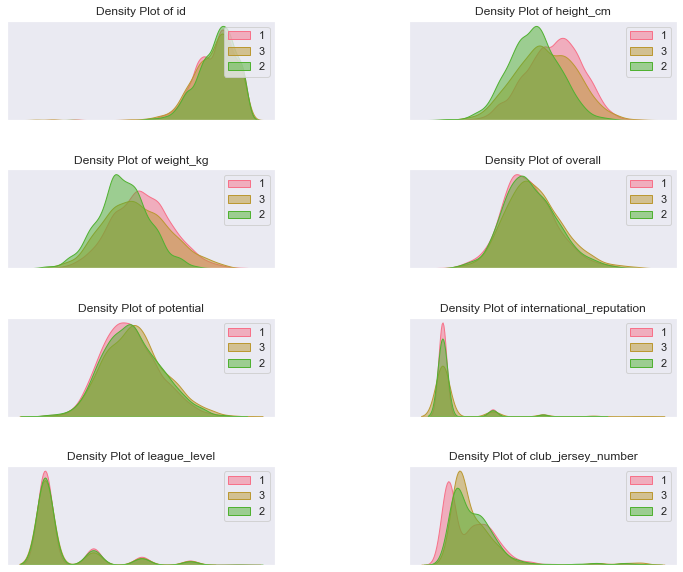

In [87]:
plot_hist_mult_h2(dk[po_1],4,2,'job_order')

In [ ]:
po_2 =['id','position',
'height_cm','weight_kg','overall','potential','international_reputation',
#'league_name',
'league_level','club_jersey_number',
#'nationality_name',
#'work_rate',
#'body_type',
#'job'
'job_order'
      ]

## Studying Players based on their position objective

In [49]:
id_player = player_char.groupby(['job'])[po_1].median().sort_values(by='job_order',ascending=True).round(3).reset_index()
id_player1 = player_char.groupby(['job'])[po_1].mean().sort_values(by='job_order',ascending=True).round(3).reset_index()

In [50]:
# Median
id_player

,job,id,height_cm,weight_kg,overall,potential,international_reputation,league_level,club_jersey_number,job_order
0,Defense,228758.0,183.0,76.0,68.0,71.0,1.0,1.0,14.0,1.0
1,Midfield,230020.0,178.0,72.0,68.0,72.0,1.0,1.0,14.0,2.0
2,Attack,227528.0,180.0,75.0,69.0,72.0,1.0,1.0,11.0,3.0


In [51]:
# MEAN
id_player1

,job,id,height_cm,weight_kg,overall,potential,international_reputation,league_level,club_jersey_number,job_order
0,Defense,224310.966,182.392,76.166,68.378,71.584,1.119,1.374,15.726,1.0
1,Midfield,226389.115,177.743,72.069,68.728,72.113,1.131,1.348,17.523,2.0
2,Attack,222708.338,180.549,74.990,69.567,72.710,1.215,1.352,17.576,3.0


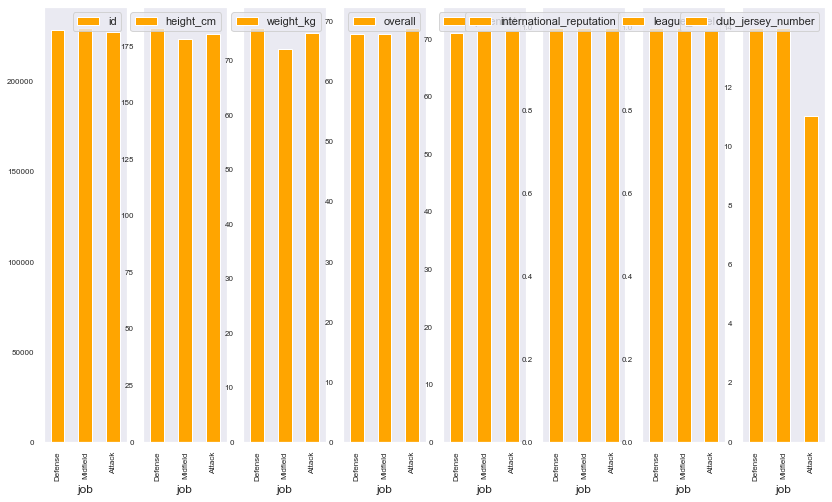

In [52]:
#Calculate CEF - MEDIAN
fp.groupby_table_med(id_player,'job')

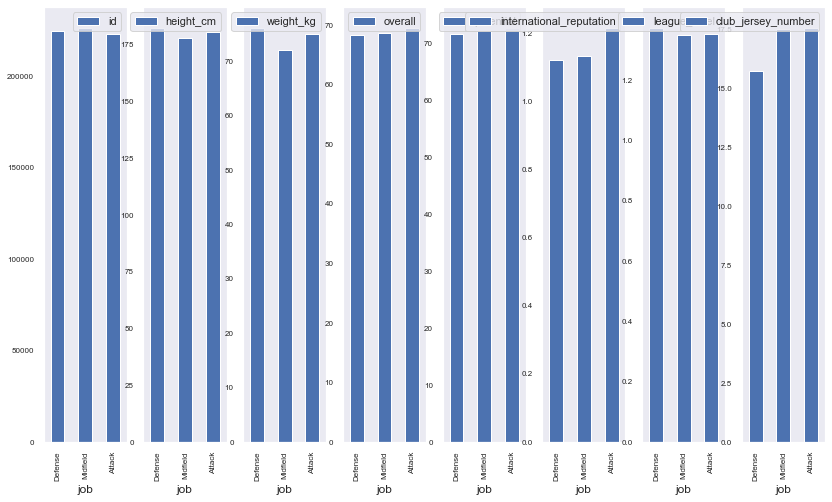

In [58]:
fp.groupby_table(id_player1,'job')

- Explore Jersey number for attackers

In [ ]:
# Create subset to analyze attackers num_jersey
plt.hist()

## Studying Players based on their position location

In [ ]:
id_player_loc = player_char.groupby(['base_position','position_loc'])[player_num_vars].mean().sort_values(by='position_ord',ascending=True).round(3).reset_index()

In [ ]:
id_player_loc.head()

In [ ]:
plt.figure(figsize=(10, 6)) 
#cpal = sns.color_palette("cmo.deep", n_colors=5)
cpal = sns.color_palette("Set2", n_colors=5)
sns.barplot(data=id_player_loc, x="base_position", y="age", hue="position_loc", palette=cpal)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Avg age per player position and location')
plt.show()

- Find attribute to differentiate CAM from other Midfielders

- Players playing in the wings are more likely to be a bit younger than those playing in centric positions

In [ ]:
plt.figure(figsize=(10, 6)) 
#cpal = sns.color_palette("cmo.deep", n_colors=5)
cpal = sns.color_palette("Set2", n_colors=5)
sns.barplot(data=id_player_loc, x="base_position", y="weight_kg", hue="position_loc", palette=cpal)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Avg age per player position and location')
plt.show()

- On the other hand, players with a larger weight tend to be positioned in central back positions or as Central Strikers.

In [ ]:
plt.figure(figsize=(10, 6)) 
#cpal = sns.color_palette("cmo.deep", n_colors=5)
cpal = sns.color_palette("Set2", n_colors=5)
sns.barplot(data=id_player_loc, x="base_position", y="international_reputation", hue="position_loc", palette=cpal)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Avg age per player position and location')
plt.show()

- No major differences

In [ ]:
id_player_wing = player_char.groupby(['base_position','is_wing'])[player_num_vars].mean().sort_values(by='position_ord',ascending=True).round(3).reset_index()

In [ ]:
id_player_wing

In [ ]:
plt.figure(figsize=(10, 6)) 
cpal = sns.color_palette("cmo.deep", n_colors=5)
#cpal = sns.color_palette("Set2", n_colors=5)
sns.barplot(data=id_player_wing, x="base_position", y="age", hue="is_wing", palette=cpal)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Avg age per player position and location')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6)) 
cpal = sns.color_palette("cmo.deep", n_colors=5)
#cpal = sns.color_palette("Set2", n_colors=5)
sns.barplot(data=id_player_wing, x="base_position", y="weight_kg", hue="is_wing", palette=cpal)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Avg age per player position and location')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6)) 
cpal = sns.color_palette("cmo.deep", n_colors=5)
#cpal = sns.color_palette("Set2", n_colors=5)
sns.barplot(data=id_player_wing, x="base_position", y="international_reputation", hue="is_wing", palette=cpal)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Avg age per player position and location')
plt.show()

## Studying Financial metrics

In [ ]:
# Player financial attributes
player_finance = df[['id','position','value_eur','wage_eur',
                     'base_position','position_loc','is_wing','position_ord']]

finance_num_vars = fp.numeric_cols(player_finance)

In [ ]:
pop_parameters(player_finance[finance_num_vars])

In [ ]:
fp.plot_hist_mult(player_finance[finance_num_vars].iloc[:,1:3],1,2,30)

In [ ]:
fp.plot_box_mult(player_finance[finance_num_vars].iloc[:,1:3],1,2)

In [ ]:
id_finance_loc = player_finance.groupby(['base_position'])[finance_num_vars].mean().sort_values(by='position_ord',ascending=True).round(3).reset_index()

In [ ]:
id_finance_loc.head()

In [ ]:
fp.groupby_table2(id_finance_loc,'base_position')

# Bivariate Analysis

In [44]:
from sklearn.preprocessing import LabelEncoder

# Sample data with nominal labels
nominal_labels = dk['position'].copy() 

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the nominal labels
enconded_labels = label_encoder.fit_transform(nominal_labels)
dk.loc[:, 'encoded_position'] = enconded_labels
# Print the original labels and the corresponding encoded values
dk


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,id,short_name,overall,potential,value_eur,wage_eur,birthday_date,height_cm,weight_kg,club_name,...,today,age,job,position_line,position_loc,is_wing,position_line_ord,job_order,side,encoded_position
0,216302,E. García,71.0,71.0,1400000.0,10000.0,1989-12-28,176.0,73.0,Club Atlético de San Luis,...,2022-11-01,32,Defense,CB,L,yes,1,1,L,4
1,237867,D. Cancola,65.0,71.0,1000000.0,2000.0,1996-10-23,183.0,73.0,Ross County FC,...,2022-11-01,26,Defense,CDM,CL,no,2,1,L,7
2,253472,E. Kahl,65.0,77.0,1600000.0,2000.0,2001-09-27,178.0,69.0,Aarhus GF,...,2022-11-01,21,Defense,CDM,L,yes,2,1,L,12
3,223994,S. Mugoša,72.0,72.0,2300000.0,5000.0,1992-02-26,188.0,81.0,Incheon United FC,...,2022-11-01,30,Attack,ST,CL,no,6,3,L,10
4,251635,A. Țigănașu,65.0,65.0,525000.0,3000.0,1990-06-12,179.0,74.0,FC Botoşani,...,2022-11-01,32,Defense,CB,L,yes,1,1,L,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,205601,C. Atsu,72.0,72.0,2300000.0,17000.0,1992-01-10,165.0,65.0,Al Raed,...,2022-11-01,30,other,other,other,no,-1,-1,NaN,23
763,223752,M. Torres,68.0,74.0,1700000.0,2000.0,1996-04-17,180.0,70.0,América de Cali,...,2022-11-01,26,other,other,other,no,-1,-1,NaN,23
764,192450,A. Cook,65.0,65.0,700000.0,6000.0,1990-10-18,185.0,80.0,Bradford City,...,2022-11-01,32,other,other,other,no,-1,-1,NaN,23
765,192366,N. Otamendi,81.0,81.0,12500000.0,18000.0,1988-02-12,183.0,76.0,SL Benfica,...,2022-11-01,34,other,other,other,no,-1,-1,NaN,23


In [45]:
numer_dk = numeric_cols(dk)

In [46]:
list_1 =[
 'weak_foot',
 'skill_moves',
 'pace',
 'shooting',
 'passing',
 'dribbling',
 'defending',
 'physic',
 'attacking_crossing',
 'attacking_finishing',
 'attacking_heading_accuracy',
 'attacking_short_passing',
 'attacking_volleys',
 'skill_dribbling',
 'skill_curve',
 'skill_fk_accuracy',
 'skill_long_passing',
 'skill_ball_control',
 'movement_acceleration',
 'movement_sprint_speed',
 'movement_agility',
 'movement_reactions',
 'movement_balance',
 'power_shot_power',
 'power_jumping',
 'power_stamina',
 'power_strength',
 'power_long_shots',
 'mentality_aggression',
 'mentality_interceptions',
 'mentality_positioning',
 'mentality_vision',
 'mentality_penalties',
 'mentality_composure',
 'defending_marking_awareness',
 'defending_standing_tackle',
 'defending_sliding_tackle',
 'num_traits',
 'age',
 'encoded_position']

In [47]:
 list_0=['encoded_position',
 'overall',
 'potential',
 'value_eur',
 'wage_eur',
 'height_cm',
 'weight_kg',
 'league_level',
 'club_jersey_number',
 'club_contract_valid_until']

In [48]:
list_2 =['encoded_position',
 'weak_foot',
 'skill_moves',
 'pace',
 'shooting',
 'passing',
 'dribbling',
 'defending',
 'physic']

In [49]:
list_3 = ['encoded_position',
    'attacking_crossing',
 'attacking_finishing',
 'attacking_heading_accuracy',
 'attacking_short_passing',
 'attacking_volleys',
 'skill_dribbling',
 'skill_curve',
 'skill_fk_accuracy',
 'skill_long_passing',
 'skill_ball_control',
 'movement_acceleration',
 'movement_sprint_speed',
 'movement_agility',
 'movement_reactions',
 'movement_balance']

In [50]:
list_4 = ['encoded_position',
'power_shot_power',
 'power_jumping',
 'power_stamina',
 'power_strength',
 'power_long_shots',
 'mentality_aggression',
 'mentality_interceptions',
 'mentality_positioning',
 'mentality_vision',
 'mentality_penalties',
 'mentality_composure'   
]

In [51]:
list_5 = [
  'encoded_position',
 'defending_marking_awareness',
 'defending_standing_tackle',
 'defending_sliding_tackle',
 'num_traits',
 'age'  
    
    
]

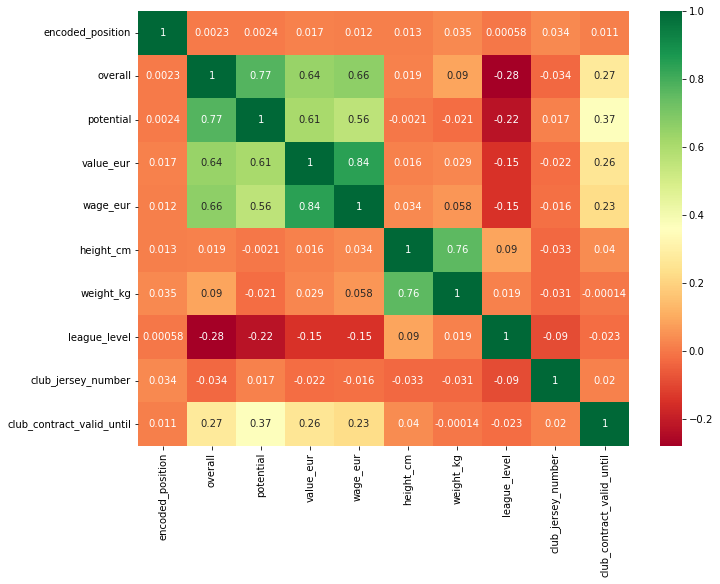

In [52]:
corr = dk[list_0].corr()
plt.figure(figsize=(11, 8))
sns.heatmap(corr, cmap="RdYlGn", annot=True)
plt.show()

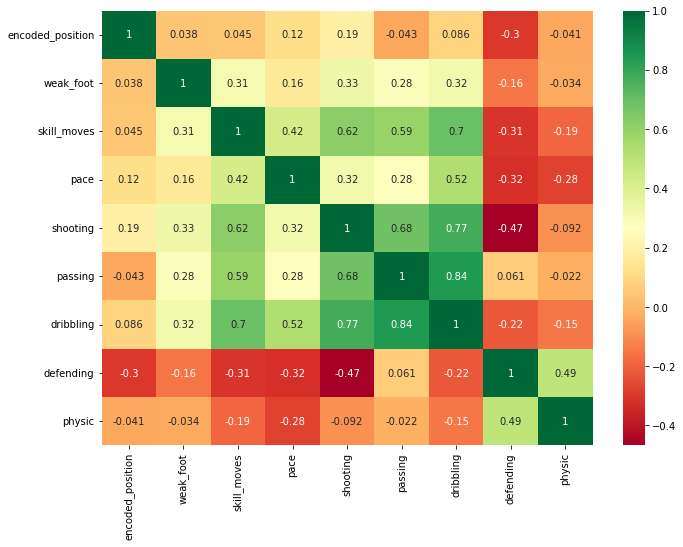

In [53]:
corr = dk[list_2].corr()
plt.figure(figsize=(11, 8))
sns.heatmap(corr, cmap="RdYlGn", annot=True)
plt.show()

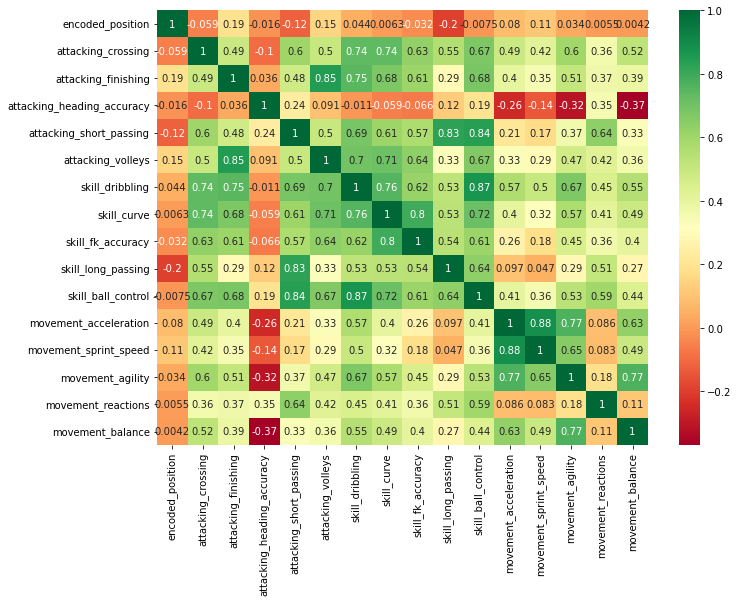

In [54]:
corr = dk[list_3].corr()
plt.figure(figsize=(11, 8))
sns.heatmap(corr, cmap="RdYlGn", annot=True)
plt.show()

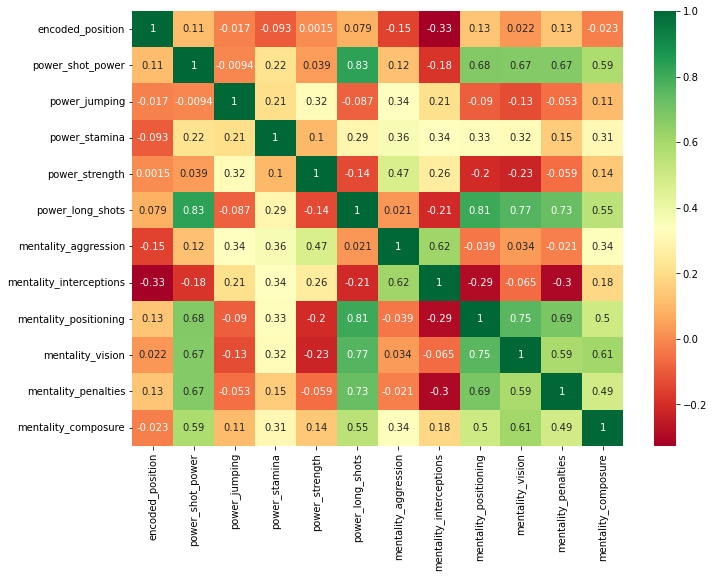

In [55]:
corr = dk[list_4].corr()
plt.figure(figsize=(11, 8))
sns.heatmap(corr, cmap="RdYlGn", annot=True)
plt.show()

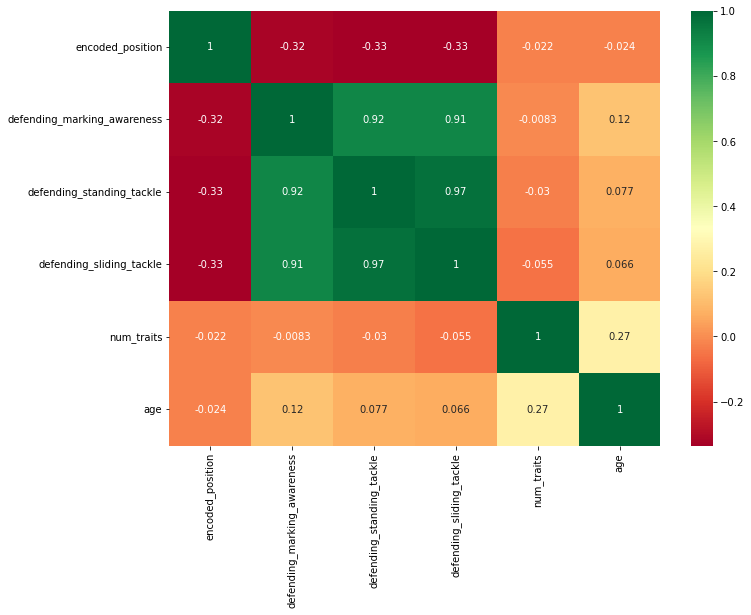

In [56]:
corr = dk[list_5].corr()
plt.figure(figsize=(11, 8))
sns.heatmap(corr, cmap="RdYlGn", annot=True)
plt.show()

# Split back again the dataframe

In [88]:
df_train = df[df['is_test'] == 0]
df_test = df[df['is_test'] == 1]

In [89]:
print(df_train.shape)
print(df_test.shape)

(6895, 71)
(767, 71)


In [90]:
lists =[
 'weak_foot',
 #'skill_moves',
 'pace',
 #'shooting',
 #'passing',
 #'dribbling',
 'defending',
 'physic',
 #'attacking_crossing',
 'attacking_finishing',
 'attacking_heading_accuracy',
 'attacking_short_passing',
 #'attacking_volleys',
 #'skill_dribbling',
 #'skill_curve',
 'skill_fk_accuracy',
 'skill_long_passing',
 'skill_ball_control',
 'movement_acceleration',
 #'movement_sprint_speed',
 #'movement_agility',
 #'movement_reactions',
 'movement_balance',
 'power_shot_power',
 'power_jumping',
 'power_stamina',
 'power_strength',
 'power_long_shots',
 'mentality_aggression',
 #'mentality_interceptions',
 #'mentality_positioning',
 #'mentality_vision',
 'mentality_penalties',
 #'mentality_composure',
 'defending_marking_awareness',
 #'defending_standing_tackle',
 #'defending_sliding_tackle',
 'num_traits',
 #'is_GK',
 'age',
 'position']

In [67]:
#df_tr = df_train[lists]

In [92]:
df_tr = df_train[df_train['is_GK']==0][lists]

In [96]:

# Create a synthetic dataset
X = df_tr.drop('position',axis=1)
y = df_tr['position']

# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Initialize a random forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=1)

# Train the random forest model
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Visualize feature importance
feature_importances = rf_classifier.feature_importances_
indices = np.argsort(feature_importances)[::-1]



Accuracy: 0.2936951316839585


In [ ]:
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(X.shape[1]), feature_importances[indices])
plt.xticks(range(X.shape[1]), indices)
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.show()

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Choose an index for the tree you want to visualize (e.g., index 0)
#tree_index = 0

# Plot the selected tree
#plt.figure(figsize=(20, 10))
#plot_tree(rf_classifier.estimators_[tree_index], filled=True, feature_names=[f'Feature_{i}' for i in range(X.shape[1])])
#plt.title(f'Decision Tree {tree_index}')
#plt.show()

# How balance is our dataset

In [ ]:
conditions = [
    dr['position'].isin(['GK']),
     dr['position'].isin(['LB','LCB','CB','RCB','RB','LWB','LDM','CDM','RDM','RWB']),
     dr['position'].isin(['LM','LCM','CM','RCM','RM']),
     dr['position'].isin(['LAM','CAM','RAM','LW','LF','CF','RF','RW','LS','ST','RS'])
     
]

choices = ['Goalkeeper', 'Defense', 'Midfield', 'Attack']

dr['job'] = np.select(conditions, choices, default='other')

In [ ]:
freq = dr.groupby('job')['id'].count().reset_index()
freq['tot'] = freq['id'].sum()
freq['perc'] = freq['id']/freq['tot']

In [ ]:
freq

In [ ]:
plt.barh(freq['job'],freq['perc'])
plt.show()

In [ ]:
freq = dr.groupby('position')['id'].count().reset_index()
freq['tot'] = freq['id'].sum()
freq['perc'] = freq['id']/freq['tot']

In [ ]:
freq.head()

In [ ]:
plt.barh(freq['position'],freq['perc'])
plt.show()